In [2]:
import matplotlib.pyplot as plt
import datajoint as dj
import numpy as np

import seaborn as sns
import pandas as pd
import blob_transformation as bt
from DMS2_utils import *
from DMS2_fetch_protocol_data import *

# settings
%load_ext autoreload
%autoreload 2
dj.blob.use_32bit_dims = True # necessary for pd.blob read
sns.set_context("talk")


In [3]:
# ANIMAL_IDS = ["R610", "R611", "R612", "R613", "R614"]
# ANIMAL_ID = "R611"
# SESSION = 911940
# bdata = dj.create_virtual_module("bdata", "bdata")
animal_ids=None
drop_trial_report=False

In [4]:
# TODO write into function!
# TODO maybe need to deal with new cols (exp min,max, tau)
animal_ids = ANIMAL_IDS if animal_ids is None else animal_ids
assert type(animal_ids) == list, "animal ids must be in a list"

animals_protocol_dfs = []

for animal_id in animal_ids:
    subject_session_key = {"ratname": animal_id}

    protocol_blobs = (bdata.Sessions & subject_session_key).fetch(
        "protocol_data", as_dict=True
    )

    # protocol data is fetched on it's own from sessions table
    # since it's n sessions x n trials/session long
    protocol_blobs = (bdata.Sessions & subject_session_key).fetch(
        "protocol_data", as_dict=True
    )

    # n session long items are fetched together
    sess_ids, dates, trials = (bdata.Sessions & subject_session_key).fetch(
        "sessid", "sessiondate", "n_done_trials"
    )
    
    protocol_blobs, sess_ids, dates, trials = drop_empty_sessions(
        protocol_blobs, sess_ids, dates, trials, drop_trial_report=drop_trial_report
    )
    # TODO think about wrapping all of these together?
    protocol_dicts = convert_to_dicts(protocol_blobs)
    protocol_dfs = convert_to_dfs(protocol_dicts, sess_ids)
    clean_protocol_dfs(protocol_dfs, animal_id, sess_ids, dates, trials)
    
    animals_protocol_df = pd.concat(protocol_dfs, ignore_index=True)

    animals_protocol_dfs.append(animals_protocol_df)

all_animals_protocol_df = pd.concat(animals_protocol_dfs)

In [5]:
all_animals_protocol_df

,trial,animal_id,date,sess_id,result,hits,violations,temperror,hit_rate,error_rate,...,water_delivered,give_water_not_drunk,crash_hist,l_water_vol,r_water_vol,ab_l_prob,ab_r_prob,ab_beta,ab_tau,sound_pair
0,1,R610,2023-04-13,911939,6.0,<NA>,<NA>,<NA>,0.0,0.0,...,6.0,True,False,20.0,20.0,1.0,0.0,0.0,30.0,"12.0, 12.0"
1,2,R610,2023-04-13,911939,6.0,<NA>,<NA>,<NA>,NaN,NaN,...,0.0,False,False,20.0,20.0,1.0,0.0,0.0,30.0,"3.0, 3.0"
2,3,R610,2023-04-13,911939,1.0,1,0,0,NaN,NaN,...,20.0,False,False,20.0,20.0,1.0,0.0,0.0,30.0,"12.0, 12.0"
3,4,R610,2023-04-13,911939,1.0,1,0,0,1.0,0.0,...,20.0,False,False,20.0,20.0,1.0,0.0,0.0,30.0,"12.0, 12.0"
4,5,R610,2023-04-13,911939,6.0,<NA>,<NA>,<NA>,1.0,0.0,...,6.0,True,False,20.0,20.0,1.0,0.0,0.0,30.0,"12.0, 12.0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,46,R614,2023-04-13,911944,6.0,<NA>,<NA>,<NA>,1.0,0.0,...,6.0,True,False,20.0,20.0,1.0,0.0,0.0,30.0,"12.0, 12.0"
46,47,R614,2023-04-13,911944,6.0,<NA>,<NA>,<NA>,1.0,0.0,...,0.0,True,False,20.0,20.0,1.0,0.0,0.0,30.0,"12.0, 12.0"
47,48,R614,2023-04-13,911944,1.0,1,0,0,1.0,0.0,...,20.0,False,False,20.0,20.0,1.0,0.0,0.0,30.0,"3.0, 3.0"
48,49,R614,2023-04-13,911944,6.0,<NA>,<NA>,<NA>,1.0,0.0,...,6.0,True,False,20.0,20.0,1.0,0.0,0.0,30.0,"12.0, 12.0"


In [118]:
"""jalskdfj"""

'jalskdfj'

In [8]:
first_poke_df = pd.melt(protocol_df, id_vars = ["trial", "first_spoke"], value_vars=["first_lpoke", "first_rpoke"])

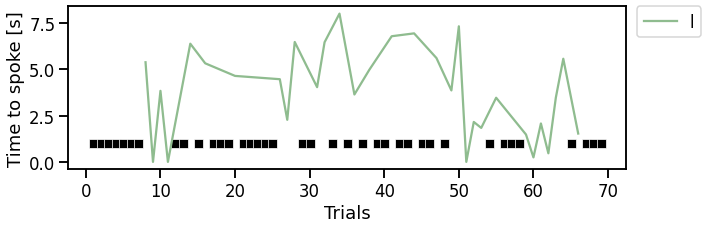

In [13]:
fig, ax = plt.subplots(figsize=(10,3))
title=""
protocol_df["was_no_answer"] = protocol_df["result"].apply(lambda row: True if row == 6.0 else np.nan)
sns.lineplot(data=first_poke_df, x="trial", y="value", ax=ax, hue="first_spoke", palette=get_poke_pallete(first_poke_df.first_spoke))
sns.scatterplot(data=protocol_df, x="trial", y="was_no_answer",ax=ax, marker='s', color="black")
_ = ax.set(ylabel="Time to spoke [s]", xlabel="Trials", title=title)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

In [22]:
calculate_daily_trial_rate("R611",protocol_df.date[0])

63.0

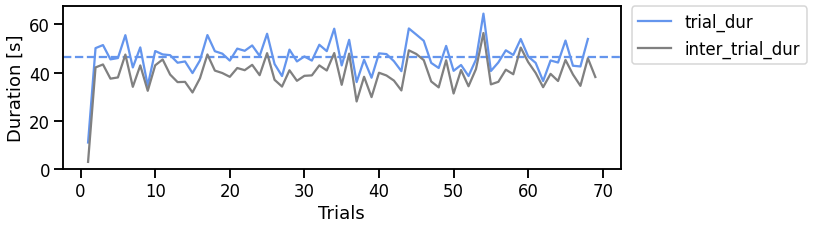

In [16]:
fig, ax = plt.subplots(figsize=(10,3))
plot_trial_and_iti_dur(protocol_df, ax)

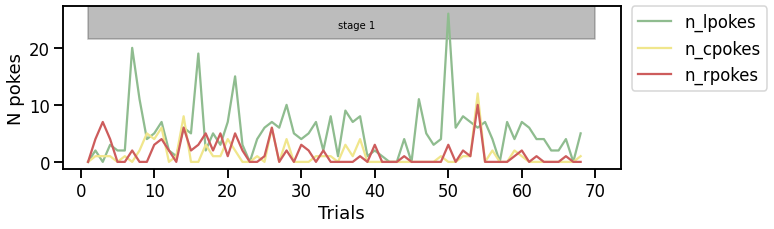

In [17]:
fig, ax = plt.subplots(figsize=(10,3))
plot_npokes_across_trials(protocol_df, ax)
# maybe histogram on the side of this plot?

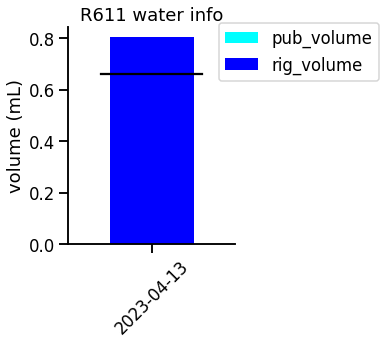

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

plot_daily_water(protocol_df, ax)

